###### A facial detection model that learns the latent variables underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigating any biases that may be present in order to train a debiased model.

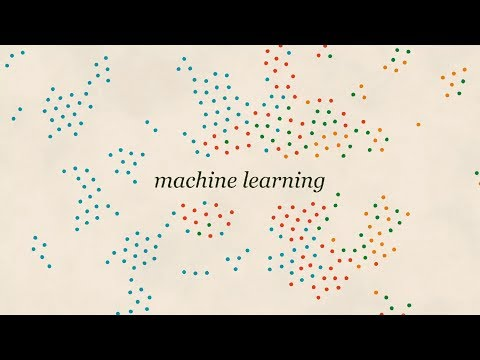

In [1]:
import IPython 
IPython.display.YouTubeVideo('59bMh59JQDo')

In [2]:
import tensorflow as tf
import IPython, functools
import matplotlib.pyplot as plt, numpy as np
from tqdm import tqdm
import mitdeeplearning as mdl

In [3]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening C:\Users\meetd\.keras\datasets\train_face.h5
Loading data into memory...


In [4]:
number_of_train_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

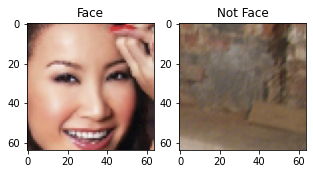

In [5]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]
idx_face = 23
idx_not_face = 9
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [6]:
def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
    ])
    return model

In [7]:
n_filters = 12
standard_classifier = make_standard_classifier()

In [8]:
BATCH_SIZE=32
EPOCHS=2
LEARNING_RATE=5e-4
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): 
    tqdm._instances.clear()
@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        logits = standard_classifier(x)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss

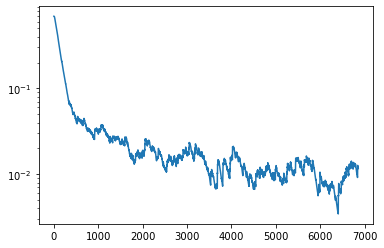

100%|██████████████████████████████████████████████████████████████████████████████| 3434/3434 [05:35<00:00, 10.24it/s]


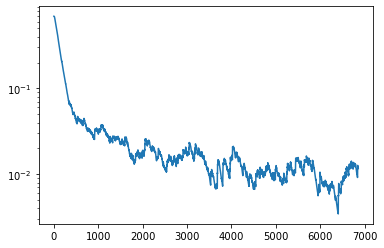

In [9]:
for epoch in range(EPOCHS):
    for idx in tqdm(range(loader.get_train_size()//BATCH_SIZE)):
        x, y = loader.get_batch(BATCH_SIZE)
        loss = standard_train_step(x, y)
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

In [16]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Standard CNN accuracy on (potentially biased) training set: {:.4f}%".format(acc_standard.numpy()*100))

Standard CNN accuracy on (potentially biased) training set: 99.7600%


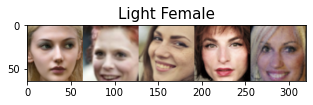

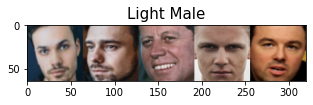

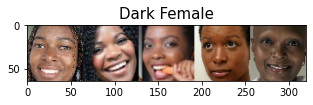

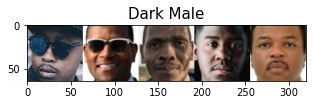

In [17]:
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
    plt.figure(figsize=(5,5))
    plt.imshow(np.hstack(group))
    plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard classifier predictions')

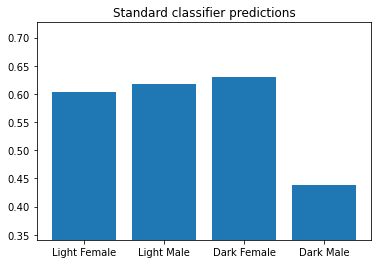

In [18]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions")

###### Variational autoencoder (VAE) for learning latent structure

In [19]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss

In [20]:
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

###### Debiasing variational autoencoder (DB-VAE)

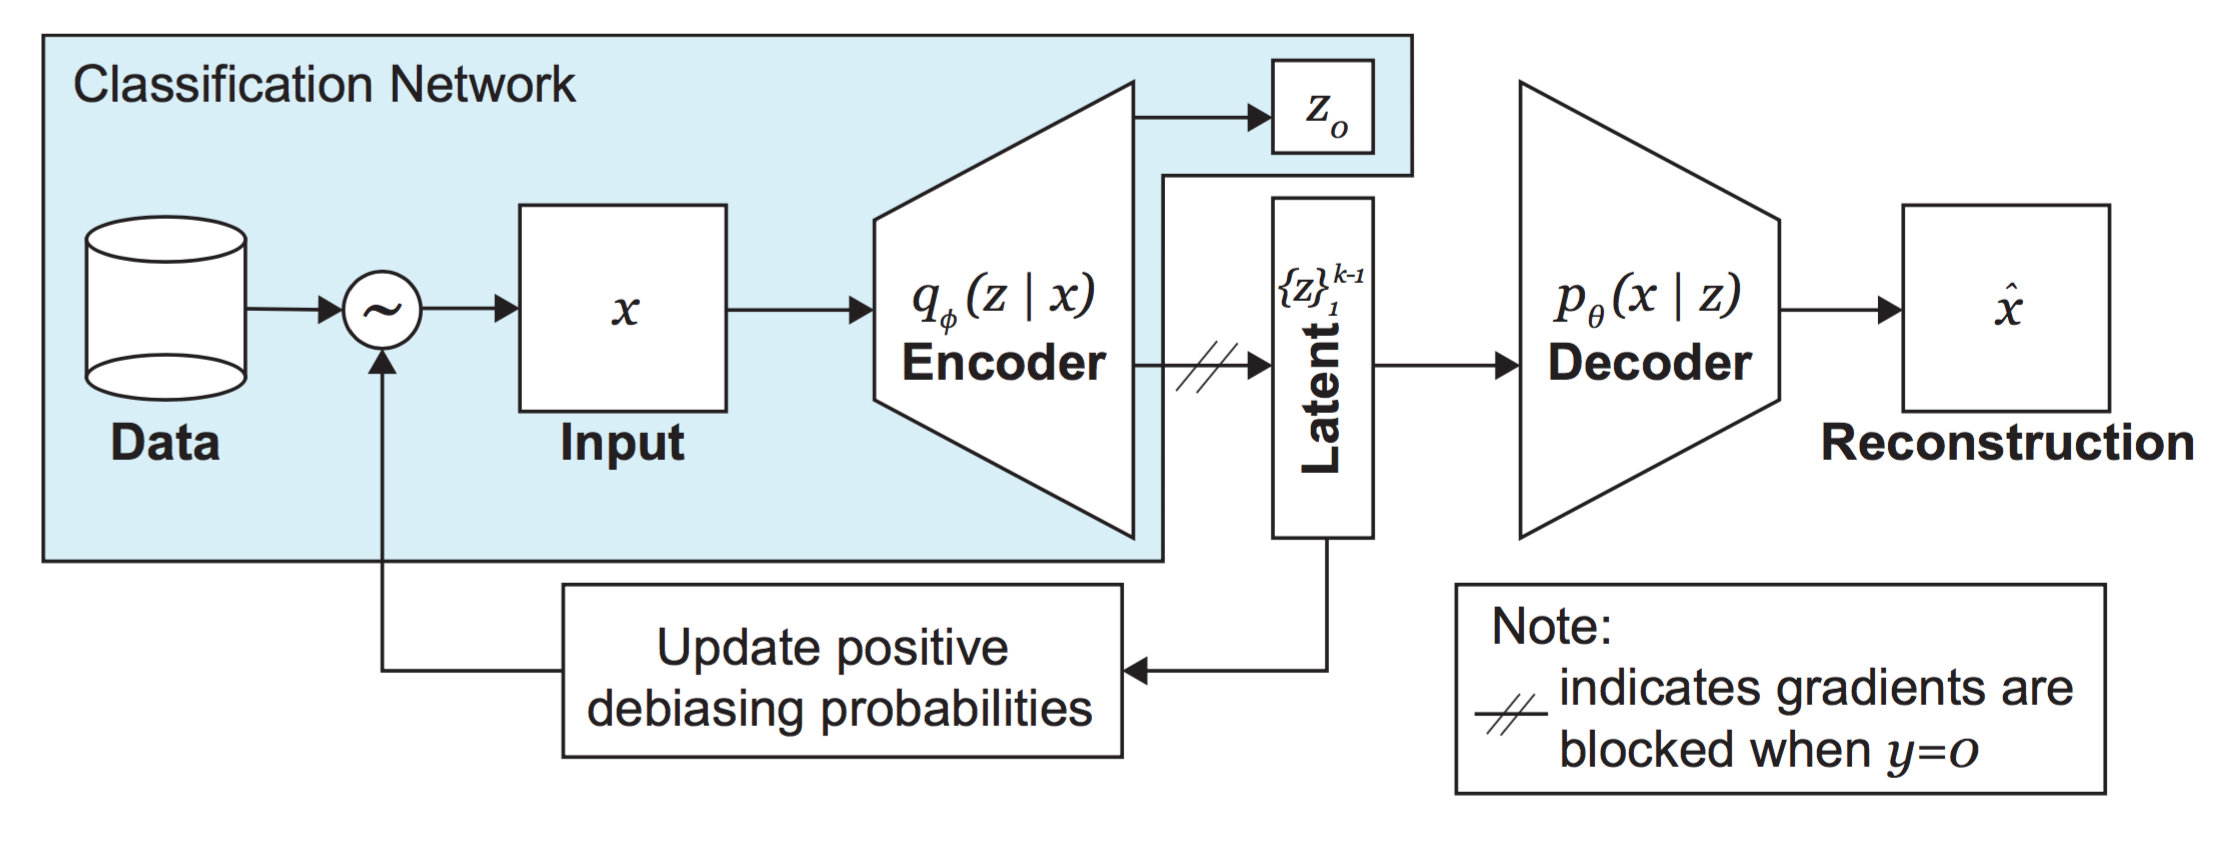

In [21]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
    total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss)
    return total_loss, classification_loss

In [22]:
n_filters = 12
latent_dim = 100 
def make_face_decoder_network():
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape
    decoder = tf.keras.Sequential([
    Dense(units=4*4*6*n_filters), 
    Reshape(target_shape=(4, 4, 6*n_filters)),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])
    return decoder

In [23]:
class DB_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim
        num_encoder_dims = 2*self.latent_dim + 1
        self.encoder = make_standard_classifier(num_encoder_dims)
        self.decoder = make_face_decoder_network()

    def encode(self, x):
        encoder_output = self.encoder(x)
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)
        z_mean = encoder_output[:, 1:self.latent_dim+1] 
        z_logsigma = encoder_output[:, self.latent_dim+1:]
        return y_logit, z_mean, z_logsigma

    def reparameterize(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma)
        return z

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def call(self, x): 
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

In [24]:
dbvae = DB_VAE(latent_dim)

In [25]:
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

In [26]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)
    return training_sample_p

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|                                                                                         | 0/3434 [00:00<?, ?it/s]

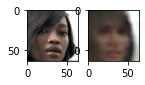

 15%|███████████▌                                                                   | 500/3434 [00:56<05:25,  9.01it/s]

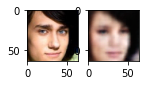

 29%|██████████████████████▋                                                       | 1000/3434 [01:52<04:26,  9.15it/s]

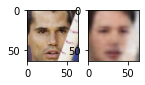

 44%|██████████████████████████████████                                            | 1500/3434 [02:47<03:34,  9.00it/s]

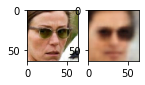

 58%|█████████████████████████████████████████████▍                                | 2000/3434 [03:43<02:39,  8.98it/s]

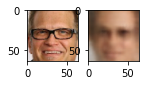

 73%|████████████████████████████████████████████████████████▊                     | 2500/3434 [04:40<01:43,  9.06it/s]

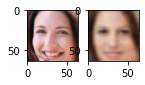

 87%|████████████████████████████████████████████████████████████████████▏         | 3000/3434 [05:36<00:49,  8.76it/s]

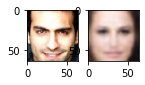

100%|██████████████████████████████████████████████████████████████████████████████| 3434/3434 [06:23<00:00,  8.95it/s]


In [27]:
batch_size = 32
learning_rate = 5e-4
latent_dim = 100
num_epochs = 6
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def debiasing_train_step(x, y):
    with tf.GradientTape() as tape:
        y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
        loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    grads = tape.gradient(loss, dbvae.trainable_variables)
    optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
    return loss

all_faces = loader.get_all_train_faces()
if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()
for i in range(num_epochs):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i+1, num_epochs))
    p_faces = get_training_sample_probabilities(all_faces, dbvae)
    for j in tqdm(range(loader.get_train_size() // batch_size)):
        (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
        loss = debiasing_train_step(x, y)
        if j % 500 == 0: 
            mdl.util.plot_sample(x, y, dbvae)

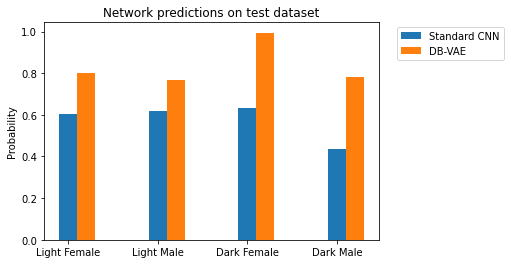

In [28]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");